In [119]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


#maintain consistent performance
tf.random.set_seed(3)

#confirm GPU is available
print("num GPUs:", len(tf.config.list_physical_devices('GPU')))

num GPUs: 1


In [108]:
dset = pd.read_csv('CData/emnist-balanced-train.csv', header=None)
dset.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,45,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [109]:
dset.describe()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
count,112800.00000,112800.0,112800.0,112800.0,112800.0,112800.000000,112800.000000,112800.000000,112800.000000,112800.000000,...,112800.000000,112800.0,112800.0,112800.000000,112800.000000,112800.0,112800.0,112800.0,112800.0,112800.0
mean,23.00000,0.0,0.0,0.0,0.0,0.001365,0.011560,0.020700,0.017438,0.018475,...,0.000310,0.0,0.0,0.002163,0.000284,0.0,0.0,0.0,0.0,0.0
std,13.56472,0.0,0.0,0.0,0.0,0.235046,1.221826,1.658797,1.602478,1.719549,...,0.104211,0.0,0.0,0.726499,0.095279,0.0,0.0,0.0,0.0,0.0
min,0.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,11.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,23.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
75%,35.00000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
max,46.00000,0.0,0.0,0.0,0.0,63.000000,192.000000,217.000000,217.000000,217.000000,...,35.000000,0.0,0.0,244.000000,32.000000,0.0,0.0,0.0,0.0,0.0


112800 rows (images), each described using 784 variables 28x28 pixels plus one column as output variable (first col).

In [110]:
dset.shape

(112800, 785)

In [111]:
# split dataset
dset = dset.loc[:,1:]
dset.shape

(112800, 784)

Image is rotated. To fix this, we have to flip it horizontally and rotate it 90 degrees anti-clockwise.
(https://stackoverflow.com/questions/48532761/letters-in-emnist-training-dataset-are-rotated-and-little-vague)

<function matplotlib.pyplot.show(close=None, block=None)>

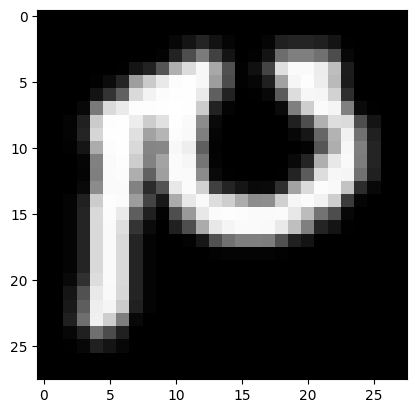

In [112]:
# normalize data
dset = np.expand_dims(dset,-1).astype('float32')/255
# reshape images to 28 x 28
dset = np.reshape(dset,(-1,28,28))
# get sample image to see what they look like
sample = dset[102]
plt.imshow(sample, cmap=plt.cm.gray)
plt.show

In [113]:
def rotate(sample):
  sample = np.fliplr(sample)
  sample = np.rot90(sample)
  return sample


<function matplotlib.pyplot.show(close=None, block=None)>

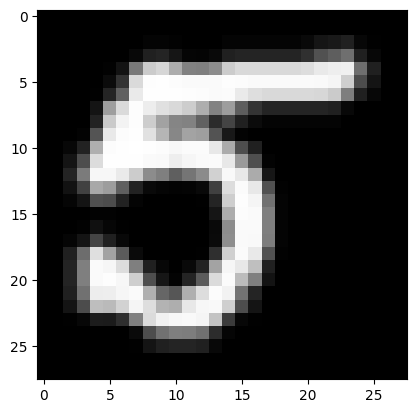

In [114]:
# Check if the rotate function worked
s1 = rotate(sample)
plt.imshow(s1, cmap=plt.cm.gray)
plt.show

In [115]:
dset = [rotate(x) for x in dset]

<function matplotlib.pyplot.show(close=None, block=None)>

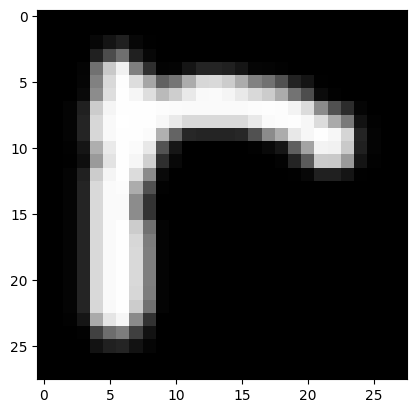

In [116]:
# check if function worked for the whole dataset by looking at random element
s2 = dset[109]
plt.imshow(s2, cmap=plt.cm.gray)
plt.show

Reshape data to dimensions needed by CNN layers, shuffle, and batch it.

In [117]:
BATCH_SIZE = 64
# convolution layers work 3 channels 
dset = np.reshape(dset,(-1,28,28,1))
# tensorflow dataset obj
dset =  tf.data.Dataset.from_tensor_slices(dset)
# set batch size for it not to read one image at a time
dset = dset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

Set up model for generator. Three COnv2DTranspose layers are used to construct the images.

In [120]:
# Generator's input is a noise vector hyperparameter (fine-tune later)
NOISE_DIM = 150

# design generator model with unsampling layers
generator = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(NOISE_DIM,)),
    layers.Dense(7*7*256),
    layers.Reshape(target_shape=(7,7,256)),
    # Three COnv2DTranspose layers are used to construct the images. Similar to VAE.
    layers.Conv2DTranspose(256,3,activation="LeakyReLU",strides=2,padding="same"),
    layers.Conv2DTranspose(128,3,activation="LeakyReLU",strides=2,padding="same"),
    layers.Conv2DTranspose(1,3,activation="sigmoid",strides=2,padding="same")
])

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1894144   
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 256)      590080    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      295040    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 56, 56, 1)        1153      
 ranspose)                                                       
                                                        

Create discriminator model. Two Conv2D layers to downsample before going into a 64-neuron dense layer and a dropout to avoid overfitting. The output is binary, as the job is to classify the character images as real or fake until it cannot tell the difference anymore.

In [121]:
# create discriminator
discriminator = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(28,28,1)),
    # activation parameters were chosen on the basis that they are standard practice in GANs.
    layers.Conv2D(256,3,activation="relu", strides=2,padding="same"),
    layers.Conv2D(128,3,activation="relu", strides=2,padding="same"),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1,activation="sigmoid")
])

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 256)       2560      
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         295040    
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 64)                401472    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 699,137
Trainable params: 699,137
Non-tr